# SCALE Tutorial
Victor C. Chan, Renée Hložek, Joel Meyers, Alexander van Engelen
https://arxiv.org/abs/2302.13350

This is a tutorial notebook designed to walk someone through the SCALE functions implemented in the `cmbpix` package.

Prerequisites:
* `numpy`
* `matplotlib`
* `scipy`'s `interp1d` method
* `cython` to speed up computation of SCALE integrals

The following are used in this notebook, but could be potentially be replaced if you want to use alternatives:
* `camb` for generating CMB power spectra
    * https://camb.readthedocs.io/en/latest/
* `pixell` for generating mock CMB maps
    * https://pixell.readthedocs.io/en/latest/
* `symlens` for well-tested implementations of quadratic estimators
    * https://symlens.readthedocs.io/en/latest/index.html
* `orphics` for manipulating map statistics
    * https://github.com/msyriac/orphics

The notebook is split between the following 4 sections:
1. Generating CMB power spectra and mocks
2. Applying a quadratic estimator to mocks
3. Applying SCALE to mocks
4. Iterating over realizations to gather statistics

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Generate CMB power spectra and mocks

In [2]:
# We will generate CMB power spectra with CAMB
import camb
pars = camb.CAMBparams()

# This function sets up CosmoMC-like settings, 
#    with one massive neutrino and helium set 
#    using BBN consistency
# Any CAMB parameters can be used here, 
#    as long as valid power spectra are produced
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
# Lensing accuracy recommended by https://arxiv.org/abs/2103.05582
pars.set_for_lmax(20000, lens_potential_accuracy=8.);
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

# Convert CAMB outputs to desired Cls
ls = np.arange(powers['unlensed_scalar'].shape[0])
## CAMB outputs l(l+1)/(2pi) * C_l by default, need to rescale
ell_fac = ls*(ls+1.)/(2*np.pi)
ctt_unlensed = (powers['unlensed_scalar'][:,0]/ell_fac)
ctt_lensed = (powers['total'][:,0]/ell_fac)
## CAMB outputs l(l+1)/(2pi) * C_l^{dd} by default, need to rescale to C_l^{phiphi}
ell_fac_phi = (ls*(ls+1.)*ls*(ls+1.))/(2*np.pi)
cphiphi = (powers['lens_potential'][:,0]/ell_fac_phi)

# Noise spectrum; these can be changed
Delta_T = 1.  # In muK-arcmin
theta_fwhm = 1.   # in arcmin
ntt = (Delta_T*np.pi/180./60.)**2. * np.exp((theta_fwhm*np.pi/180./60. / np.sqrt(8.*np.log(2)))**2.*ls**2.)

# Add lensed + noise power spectra
ctt_total = ctt_lensed + ntt

# This removes potential NaNs in the power spectra
ctt_unlensed[0] = 0
ctt_lensed[0] = 0
cphiphi[0] = 0

/tmp/ipykernel_1712/3147107032.py:21: RuntimeWarning: invalid value encountered in divide
  ctt_unlensed = (powers['unlensed_scalar'][:,0]/ell_fac)
/tmp/ipykernel_1712/3147107032.py:22: RuntimeWarning: invalid value encountered in divide
  ctt_lensed = (powers['total'][:,0]/ell_fac)
/tmp/ipykernel_1712/3147107032.py:25: RuntimeWarning: invalid value encountered in divide
  cphiphi = (powers['lens_potential'][:,0]/ell_fac_phi)


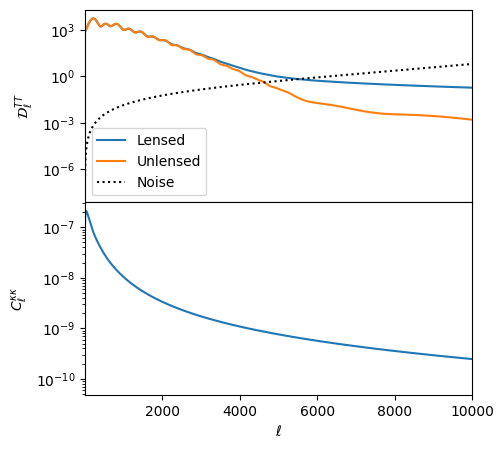

In [3]:
# Plot the power spectra
f, axs = plt.subplots(2, 1, sharex=True, figsize=(5,5))
f.subplots_adjust(hspace=0)
axs[0].plot(ls, ell_fac*ctt_lensed, label='Lensed')
axs[0].plot(ls, ell_fac*ctt_unlensed, label='Unlensed')
axs[0].plot(ls, ell_fac*ntt, c='k', ls=':', label='Noise')
axs[0].set(yscale='log', 
           ylabel=r'$\mathcal{D}_\ell^{TT}$')
axs[0].legend()
# Convert from potential to convergence
axs[1].plot(ls, (ls*(ls+1))**2 * cphiphi/4)
axs[1].set(xlim=(2,10000), 
           yscale='log', 
           xlabel=r'$\ell$', 
           ylabel=r'$C_\ell^{\kappa\kappa}$')
axs[0].legend()
plt.show()

In [4]:
# Generate mock CMB realizations with pixell
from pixell import enmap, utils, lensing

# We will work with a small map, but this can be changed
width = 10 # in degrees
height = 10 # in degrees
reso = 0.5 # pixel width in arcmin
box = np.array([[-height/2,width/2],[height/2,-width/2]]) * utils.degree
shape, wcs = enmap.geometry(pos=box, res=reso*utils.arcmin, proj='car')

The following cell can be run to get new realizations

In [5]:
# Generate noise, temperature, phi maps
nmap = enmap.rand_map(shape, wcs, ntt, scalar=True)
Tmap = enmap.rand_map(shape, wcs, ctt_unlensed, scalar=True)
phimap = enmap.rand_map(shape, wcs, cphiphi, scalar=True)
# Lens the temperature map with built-in pixell method
lTmap = lensing.lens_map(Tmap, enmap.grad(phimap))

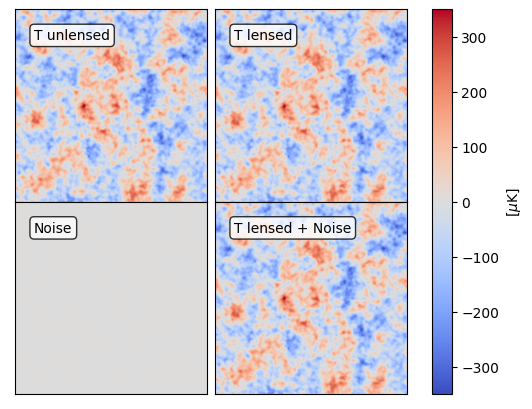

In [6]:
# Visualize CMB mocks
f, axs = plt.subplots(2, 2, 
                      sharex=True, sharey=True, 
                      figsize=(5,5))
f.subplots_adjust(left=0, right=1, hspace=0, wspace=0)
mapkws = dict(vmin=-350, vmax=350, 
              cmap='coolwarm') # Common plot options
tbox = dict(boxstyle='round', facecolor='w', 
            alpha=0.8) # Text boxes
textkws = dict(va='top', ha='left', bbox=tbox) # Text options
im = axs[0,0].imshow(Tmap, **mapkws)
axs[0,0].text(0.1, 0.9, 'T unlensed', 
              transform=axs[0,0].transAxes, **textkws)
axs[0,1].imshow(lTmap, **mapkws)
axs[0,1].text(0.1, 0.9, 'T lensed', 
              transform=axs[0,1].transAxes, **textkws)
axs[1,0].imshow(nmap, **mapkws)
axs[1,0].text(0.1, 0.9, 'Noise', 
              transform=axs[1,0].transAxes, **textkws)
axs[1,1].imshow(lTmap+nmap, **mapkws)
axs[1,1].text(0.1, 0.9, 'T lensed + Noise', 
              transform=axs[1,1].transAxes, **textkws)
axs[1,1].set(xticks=[], yticks=[])
# cb_ax = f.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = f.colorbar(im, ax=axs.ravel().tolist(), label=r'[$\mu$K]')
plt.show()

## 2. Apply a quadratic estimator to mocks

In [7]:
# We will use symlens implentations of QEs
from symlens import qe, interp
# We will use orphics for manipulating map statistics
from orphics.maps import mask_kspace, FourierCalc, binned_power
from orphics.stats import bin2D
# We will use interp1d to estimate the observed ClTT
from scipy.interpolate import interp1d

# Here we will generate masks for the QE. In principle, 
#    these options can be changed.
# Large scale temperature filter limits
lmin = 2; lmax = 3000
# Small scale temperature filter limits
ellmin = 2 ; ellmax = 10000
# Recontruction limits
Lmin = 2 ; Lmax = 12000
# Create masks with the above settings
xmask = mask_kspace(shape,wcs,lmin=lmin,lmax=lmax)
ymask = mask_kspace(shape,wcs,lmin=ellmin,lmax=ellmax)
kmask = mask_kspace(shape,wcs,lmin=Lmin,lmax=Lmax)

# Need the grid of ls for interpolation
modlmap = Tmap.modlmap()

# Set up inputs for QE
feed_dict = {}
feed_dict['uC_T_T'] = interp(ls, ctt_lensed)(modlmap) # Lensed ClTT
feed_dict['tC_T_T'] = interp(ls, ctt_total)(modlmap) # Total ClTT
feed_dict['nC_T_T'] = interp(ls, ctt_total)(modlmap) # Total ClTT

# Use these to bin QE outputs
bin_edges_phi = np.arange(0,Lmax,20)
binner_phi = bin2D(modlmap,bin_edges_phi)

# Compute the optimal reconstruction noise; independent of realization
N_l_phi_TT = qe.N_l_optimal(shape, wcs, feed_dict, 
                            estimator='hdv', XY='TT',
                            xmask=xmask, ymask=ymask, 
                            field_names=None, kmask=kmask)
cents_phi, N0_l_bin_TT = binner_phi.bin(N_l_phi_TT)

/home/vchan/.local/lib/python3.8/site-packages/orphics/stats.py:766: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized[keep],(data2d).reshape(-1)[keep])[1:-1]/count


Code in this following cell can be re-run for every new realization set of {`Tmap`, `lTmap`, `nmap`} generated

In [8]:
# We are using the TT estimator, 
#    so give it the lensed T + noise map
feed_dict['X'] = enmap.fft(lTmap+nmap, normalize='phys')
feed_dict['Y'] = feed_dict['X']
# We need the observed ClTT to compute the 
#    realization-dependent reconstruction noise bias
Dbins = np.arange(20,20000,20)
Dbinner = bin2D(modlmap,Dbins)
dcents, C_l_tot = Dbinner.bin(np.abs(enmap.fft(lTmap+nmap, 
            normalize='phys'))**2) # Observed TT auto-spectrum
feed_dict['dC_T_T'] = interp1d(dcents, C_l_tot, 
            bounds_error=False, fill_value=0)(modlmap) # Interpolate binned auto-spectrum

# Reconstruct the lensing convergence with the HDV QE
TT_reconst = qe.reconstruct(shape, wcs, feed_dict, 
                            estimator='hdv', XY='TT', 
                            xmask=xmask, ymask=ymask)
cents_phi, reconst_bin = binner_phi.bin(np.abs(TT_reconst)**2)

# Estimate the realization-dependent reconstruction noise
rdn0_2d = qe.RDN0_analytic(shape, wcs, feed_dict, 
                           alpha_estimator='hdv', alpha_XY='TT',
                           beta_estimator='hdv', beta_XY='TT', 
                           xmask=xmask, ymask=ymask, kmask=kmask)
cents_phi, RDN0_l_bin = binner_phi.bin(rdn0_2d)

/home/vchan/.local/lib/python3.8/site-packages/orphics/stats.py:766: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized[keep],(data2d).reshape(-1)[keep])[1:-1]/count
/home/vchan/.local/lib/python3.8/site-packages/orphics/stats.py:766: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized[keep],(data2d).reshape(-1)[keep])[1:-1]/count


In [9]:
# Compute the actual, underlying convergence map.
#    Recall that we used phimap to lens our mock map
dy_p, dx_p = enmap.grad(phimap)
dyy_p, dyx_p = enmap.grad(dy_p)
dxy_p, dxx_p = enmap.grad(dx_p)
k_map = -0.5 * (dyy_p + dxx_p)
# Auto-spectrum of underlying k realization
cents_phi, kk_real_bin = binned_power(k_map, bin_edges_phi)
# Convert reconstructed kappa map into pixel space
Krecon = enmap.ifft(TT_reconst, normalize='phys')
# Compute the cross-spectrum between the reconstruction, 
#    and the underlying realization
Kcor = FourierCalc(shape, wcs)
cross2d = Kcor.power2d(Krecon, k_map)
cents_phi, cross_bin = binner_phi.bin(cross2d[0])

/home/vchan/.local/lib/python3.8/site-packages/orphics/stats.py:766: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized[keep],(data2d).reshape(-1)[keep])[1:-1]/count
/home/vchan/.local/lib/python3.8/site-packages/orphics/stats.py:766: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized[keep],(data2d).reshape(-1)[keep])[1:-1]/count


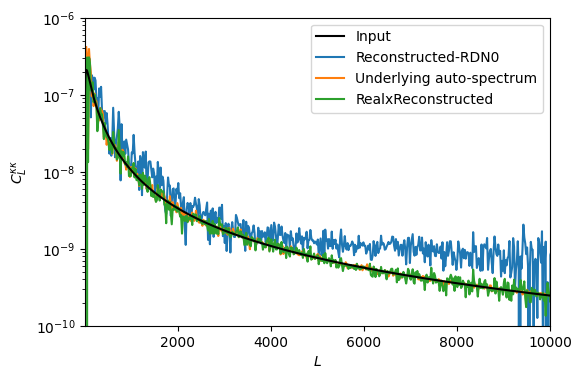

In [10]:
# Plot HDV quadratic estimator outputs & comparison
f, ax = plt.subplots(figsize=(6,4))
ax.plot(ls, (ls*(ls+1))**2 * cphiphi/4, c='k', zorder=9, label='Input')
ax.plot(cents_phi, reconst_bin-RDN0_l_bin, label='Reconstructed-RDN0')
ax.plot(cents_phi, kk_real_bin, label='Underlying auto-spectrum')
ax.plot(cents_phi, cross_bin, label='RealxReconstructed')
ax.set(xlim=(2,10000), ylim=(1e-10,1e-6), yscale='log', 
       xlabel=r'$L$', ylabel=r'$C_L^{\kappa\kappa}$')
ax.legend()
plt.show()

We first see that the reconstruction works well because its cross-spectrum with the underlying lensing realization closely matches the underlying realization's auto-spectrum as well as the input power spectrum.

We also see that the reconstructed map's auto-spectrum has some leftover bias even after removing the expected realization-dependent N0 reconstruction noise, which likely comes from higher order N1 reconstruction noise.

## 3. Applying SCALE to the same mocks

There is a method `CalcBiasExp()` included in `cmbpix.lensing.SCALE` to compute the expected SCALE outputs from theory, and there is an example of how to use it in `scripts/testIntegrals.py`.

That implementation is currently incompatible with Jupyter notebooks, so we redefine it here for our use. This will require `cython`, and can still take some time to run depending on your machine.

In [11]:
%load_ext cython

In [12]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

cimport cython
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def Psi_and_A_cy(int L, double[:] ClTTunlensed, double[:] ClTTtotal, double[:] Clphiphi, \
                 int l1min, int l1max, int l2min, int l2max, int dl1, int dl2):
    
    cdef int l1x
    cdef int l1y
    cdef int l2x
    cdef int l2y
    cdef int nl1
    cdef int l1max_round
    nl1 = l1max/dl1
    l1max_round = nl1*dl1
    cdef int nl2
    cdef int l2max_round
    nl2 = l2max/dl2
    l2max_round = nl2*dl2
    #print(lmax_round)
    
    cdef int l1dotl1minusL
    cdef int l2dotl2minusl1
    cdef int Lminusl2dotl1minusl2
    cdef int l2dotl2minusL
    
    cdef int modl1
    cdef int modLminusl1
    cdef int modl2
    cdef int modLminusl2
    cdef int modl1minusl2
    
    cdef double integrand = 0.
    cdef double integral = 0.
    cdef double AL = 0.
    
    #for l1x from -lmax <= l1x < lmax by dl:
    for l1x in prange(-l1max_round, l1max_round+1, dl1, nogil = True):
        for l1y from -l1max_round <= l1y < l1max_round+1 by dl1:
            modl1 = <int> ((l1x*l1x+l1y*l1y)**(0.5))
            modLminusl1 = <int> (((L-l1x)*(L-l1x) + l1y*l1y)**(0.5))
            if (modl1 < l1min or modl1 > l1max):
                integral += 0.
            elif (modLminusl1 < l1min or modLminusl1 > l1max):
                integral += 0.
            else:
                l1dotl1minusL = l1x*(l1x-L) + l1y*(l1y)
                for l2x from -l2max_round <= l2x < l2max_round+1 by dl2:
                    for l2y from -l2max_round <= l2y < l2max_round+1 by dl2:
                        modl2 = <int> ((l2x*l2x+l2y*l2y)**(0.5))
                        modLminusl2 = <int> (((L-l2x)*(L-l2x) + l2y*l2y)**(0.5))
                        if (modl2 < l2min or modl2 > l2max):
                            integral += 0.
                        elif (modLminusl2 < l2min or modLminusl2 > l2max):
                            integral += 0.
                        else:
                            l2dotl2minusl1 = l2x*(l2x-l1x) + l2y*(l2y-l1y)
                            Lminusl2dotl1minusl2 = (L-l2x)*(l1x-l2x) + (-l2y)*(l1y-l2y)
                            l2dotl2minusL = l2x*(l2x-L) + l2y*(l2y)
                            modl1minusl2 = <int> (((l1x-l2x)*(l1x-l2x) + (l1y-l2y)*(l1y-l2y))**(0.5))

                            integrand = 2. \
                                * 1./(ClTTtotal[modl1] * ClTTtotal[modLminusl1]) \
                                * (ClTTunlensed[modl2]*ClTTunlensed[modl2]/ClTTtotal[modl2]) \
                                * (ClTTunlensed[modLminusl2]*ClTTunlensed[modLminusl2]/ClTTtotal[modLminusl2]) \
                                * l1dotl1minusL * l2dotl2minusl1 * Lminusl2dotl1minusl2 * l2dotl2minusL
                            
                            AL += integrand
                            integral += integrand*Clphiphi[modl1minusl2]
    
    integral *= dl1*dl1*dl2*dl2
    AL *= dl1*dl1*dl2*dl2
    AL = 1./AL
    # Results need to be scaled by (2\pi)^4
    
    return integral, AL

In [13]:
# Setup SCALE parameters
#    We choose a bin size commensurate with the 
#    fundamental mode of our maps. 
#    (10x10 sq.deg. --> lfun=36)
dLv = 72
nLv = 2000 // dLv # We will consider up to Lv=2000
Lv = np.arange(dLv/2, (nLv+1)*dLv, dLv, dtype=int)
l1min = 6000; l1max = 8000 # Small-scale window
l2min = 2; l2max = 3000 # Large-scale window
# These are the theory integral binning.
#    Choose smaller values in dl1 for higher accuracy, 
#    but there is a large trade-off with computation time.
dl1 = 75; dl2=100

The following cell can be run once per choice in theory, since the expected SCALE spectra are independent of realization

In [14]:
%%time
ALv = np.zeros(np.shape(Lv)[0])
PsiLv = np.zeros(np.shape(Lv)[0])
for iL, LL in enumerate(Lv):
    # This Eq. 17-18
    PsiLv[iL], ALv[iL] = Psi_and_A_cy(L=LL, 
                            ClTTunlensed=ctt_unlensed, 
                            ClTTtotal=ctt_total, 
                            Clphiphi=cphiphi, 
                            l1min=l1min, 
                            l1max=l1max, 
                            l2min=l2min, 
                            l2max=l2max, 
                            dl1=dl1, 
                            dl2=dl2)
ALv *= (2*np.pi)**4
# Normalize PsiLv with ALv
PsiLv *= ALv/(2*np.pi)**4

# We can also compute the expected SCALE scatter
#    with Eq. 19
fsky = 100 * (np.pi**2 / 180**2) / (4*np.pi) # 100sq.deg.
dPsiLv = np.sqrt((PsiLv**2 + 4*ALv) / (fsky*dLv*(2*Lv+1)))

CPU times: user 1min 5s, sys: 35.2 ms, total: 1min 5s
Wall time: 3.83 s


Code in this following cell can be re-run for every new realization set of {`Tmap`, `lTmap`, `nmap`} generated

In [15]:
# The SCALE method from cmbpix.lensing 
#    takes in the window filter limits, as well as
#    fiducial power spectra, and applies the steps
#    in Section 4 (summaries in Figure 6).
from cmbpix.lensing import SCALE
Lvcents,SCALEout,_,_ = SCALE.SCALE(map_in=lTmap+nmap, 
                        map_delens=None, # Don't simulate delensing
                        l1min=l1min, # Small-scale window limits
                        l1max=l1max, 
                        l2min=l2min, # Large-scale window limits
                        l2max=l2max, 
                        DLv=dLv, # Binning from before
                        uCl=ctt_unlensed, # Fiducial power spectrum
                        lCl=ctt_lensed, # Fiducial power spectrum
                        Nl=ntt, # TT Noise spectrum
                        Clpp=cphiphi, # Fiducial power spectrum
                        w=Delta_T, # These two are the noise configuration
                        b=theta_fwhm, # Technically unneeded if ntt given
                        compute_bias=False # Option to compute expected theory, but we've done this already
                        )
Lvcents = Lvcents[:Lv.size]
SCALEout = ALv*SCALEout[:Lv.size] # Remember to normalize

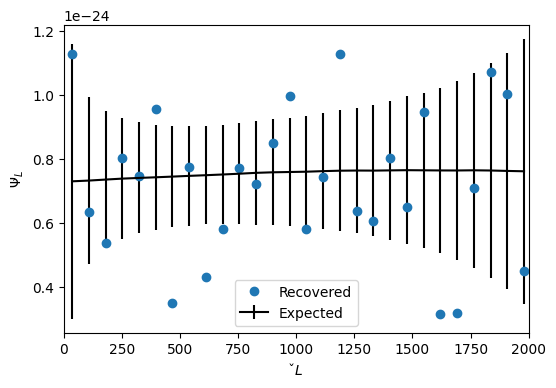

In [16]:
f, ax = plt.subplots(figsize=(6,4))
ax.errorbar(Lv, PsiLv, yerr=dPsiLv, c='k', label='Expected')
ax.plot(Lv, SCALEout, 'o', label='Recovered')
ax.set(xlim=(0,2000), 
       xlabel=r'$\check{L}$', ylabel=r'$\Psi_{\check{L}}$')
ax.legend()
plt.show()

In [17]:
# Check the reduced chi2 
#    to make sure we get the right scatter.
print(np.sum((SCALEout-PsiLv)**2 / dPsiLv**2) / Lv.size)

1.1388935186550213


The SCALE output should agree relatively well with theory.

## 4. Gathering statistics over multiple simulations

We will just take the cells from above that need to applied to each realization, and iterate over them over the desired number of sims.

This is just a proof-of-concept, and you will unlikely be able to get meaningful statistics with the amount of sims that you can do with a Jupyter notebook.

In [18]:
# Change the number of sims as desired, but be wary of
#    computation time.
Nsim = 10
# Places to store QE/SCALE outputs
#    Only store QE outputs with SCALE overlap
iLqe = ((cents_phi >= l1min) & (cents_phi < l1max))
Lqe = cents_phi[iLqe]
QEsims = np.zeros((Nsim, Lqe.size))
SCALEsims = np.zeros((Nsim, Lv.size))

In [19]:
# You may get a lot of warnings from this cell, which is usually fine
for n in range(Nsim):
    # Generate noise, temperature, phi maps
    nmap = enmap.rand_map(shape, wcs, ntt, scalar=True)
    Tmap = enmap.rand_map(shape, wcs, ctt_unlensed, scalar=True)
    phimap = enmap.rand_map(shape, wcs, cphiphi, scalar=True)
    # Lens the temperature map with built-in pixell method
    lTmap = lensing.lens_map(Tmap, enmap.grad(phimap))

    # We are using the TT estimator, 
    #    so give it the lensed T + noise map
    feed_dict['X'] = enmap.fft(lTmap+nmap, normalize='phys')
    feed_dict['Y'] = feed_dict['X']
    # We need the observed ClTT to compute the 
    #    realization-dependent reconstruction noise bias
    Dbins = np.arange(20,20000,20)
    Dbinner = bin2D(modlmap,Dbins)
    dcents, C_l_tot = Dbinner.bin(np.abs(enmap.fft(lTmap+nmap, 
                normalize='phys'))**2) # Observed TT auto-spectrum
    feed_dict['dC_T_T'] = interp1d(dcents, C_l_tot, 
                bounds_error=False, fill_value=0)(modlmap) # Interpolate binned auto-spectrum

    # Reconstruct the lensing convergence with the HDV QE
    TT_reconst = qe.reconstruct(shape, wcs, feed_dict, 
                                estimator='hdv', XY='TT', 
                                xmask=xmask, ymask=ymask)
    cents_phi, reconst_bin = binner_phi.bin(np.abs(TT_reconst)**2)

    # Estimate the realization-dependent reconstruction noise
    rdn0_2d = qe.RDN0_analytic(shape, wcs, feed_dict, 
                               alpha_estimator='hdv', alpha_XY='TT',
                               beta_estimator='hdv', beta_XY='TT', 
                               xmask=xmask, ymask=ymask, kmask=kmask)
    cents_phi, RDN0_l_bin = binner_phi.bin(rdn0_2d)

    # The SCALE method from cmbpix.lensing 
    #    takes in the window filter limits, as well as
    #    fiducial power spectra, and applies the steps
    #    in Section 4 (summaries in Figure 6).
    from cmbpix.lensing import SCALE
    Lvcents,SCALEout,_,_ = SCALE.SCALE(map_in=lTmap+nmap, 
                            map_delens=None, # Don't simulate delensing
                            l1min=l1min, # Small-scale window limits
                            l1max=l1max, 
                            l2min=l2min, # Large-scale window limits
                            l2max=l2max, 
                            DLv=dLv, # Binning from before
                            uCl=ctt_unlensed, # Fiducial power spectrum
                            lCl=ctt_lensed, # Fiducial power spectrum
                            Nl=ntt, # TT Noise spectrum
                            Clpp=cphiphi, # Fiducial power spectrum
                            w=Delta_T, # These two are the noise configuration
                            b=theta_fwhm, # Technically unneeded if ntt given
                            compute_bias=False # Option to compute expected theory, but we've done this already
                            )
    Lvcents = Lvcents[:Lv.size]
    SCALEout = ALv*SCALEout[:Lv.size] # Remember to normalize
    
    # Store outputs
    QEsims[n] = (reconst_bin-RDN0_l_bin)[iLqe]
    SCALEsims[n] = SCALEout

/home/vchan/.local/lib/python3.8/site-packages/orphics/stats.py:766: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized[keep],(data2d).reshape(-1)[keep])[1:-1]/count
/home/vchan/.local/lib/python3.8/site-packages/orphics/stats.py:766: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized[keep],(data2d).reshape(-1)[keep])[1:-1]/count
/home/vchan/.local/lib/python3.8/site-packages/orphics/stats.py:766: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized[keep],(data2d).reshape(-1)[keep])[1:-1]/count
/home/vchan/.local/lib/python3.8/site-packages/orphics/stats.py:766: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized[keep],(data2d).reshape(-1)[keep])[1:-1]/count
/home/vchan/.local/lib/python3.8/site-packages/orphics/stats.py:766: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized[keep],(data2d).reshape(-1)[keep])[1:

In [20]:
# Compute correlation matrices
SCALEcov = np.cov(SCALEsims, rowvar=False)
SCALEdiag = np.sqrt(np.diag(SCALEcov))
SCALEcor = SCALEcov / np.outer(SCALEdiag, SCALEdiag)
QEcov = np.cov(QEsims, rowvar=False)
QEdiag = np.sqrt(np.diag(QEcov))
QEcor = QEcov / np.outer(QEdiag, QEdiag)

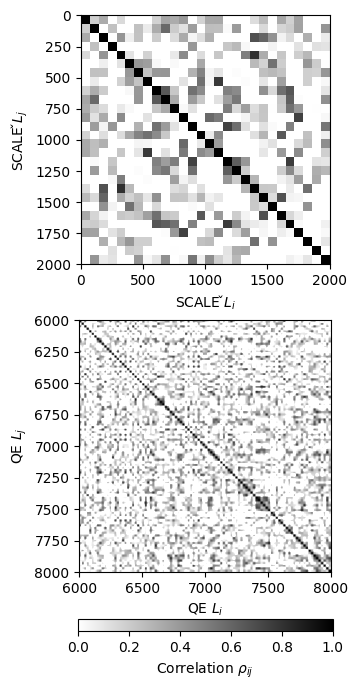

In [21]:
# Plot correlation matrices
f, axs = plt.subplots(2, 1, figsize=(5,8), 
                      gridspec_kw={'height_ratios': [4, 5]})
corkws = dict(vmin=0, vmax=1, cmap='binary', 
              interpolation=None) # Common args
im = axs[0].imshow(SCALEcor, extent=[0,2000,2000,0], **corkws)
axs[0].set(xlabel=r'SCALE $\check{L}_i$', ylabel=r'SCALE $\check{L}_j$')
axs[1].imshow(QEcor, extent=[6000,8000,8000,6000], **corkws)
axs[1].set(xlabel=r'QE $L_i$', ylabel=r'QE $L_j$')
f.colorbar(im, orientation='horizontal', 
           ax=axs[1], fraction=0.041, 
           label=r'Correlation $\rho_{ij}$')
plt.show()

The correlation matricesdo not appear to match Figure 10 because we haven't performed enough simulations to get a good handle of the statistics for either method.